# Customer Segmentation for Online Retail

### Data Loading

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# load data
df = pd.read_csv("customer_segmentation_file.csv")
df.head()

,ID,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# About the Dataset:
The dataset has details of 541,909 entries with the following 8 features

* InvoiceNo: Invoice number  <br>
* StockCode: Stock code<br>
* Description: Items details<br>
* Quantity: Quantity purchase by customer<br>
* InvoiceDate: Invoice Date on which item purchased<br>
* UnitPrice: Price of the item<br>
* CustomerID: Customer id<br>
* Country: Country name<br>

In [3]:
df['Country'].value_counts()[:10]

United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Netherlands         2371
Belgium             2069
Switzerland         2002
Portugal            1519
Australia           1259
Name: Country, dtype: int64

In [4]:
# check the null values
df.isnull().sum()
# drop null values
df.dropna(subset=['Description','CustomerID'],inplace=True)
# check the null values
df.isnull().sum()
# only take one country
df = df[df.Country== 'United Kingdom']

In the InvoiceNo there are some entries which contains C before the number it means that customer returns the item. So create the new column Return where InvoiceNo contains the C

In [5]:
# create new colums returns
df['Return']=df.InvoiceNo.str.contains('C')
# store the result in purchase 
df['Purchase'] = np.where(df["Return"]==True,0,1)

In [6]:
df.head()

,ID,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Return,Purchase
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,False,1
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,False,1
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,False,1
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,False,1
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,False,1


## Create customer-level dataset 
The aim is to create a customer-level dataset and add recency, frequency, and monetary value data to it.first calculate the recency. The recency variable refers to the number of days that have elapsed since the customer last purchased something (so, smaller numbers indicate more recent activity on the customer’s account)

In [7]:
# Create a new dataframe using pd.Dataframewhich takes the unique CustomerID 
# and use the dtype = int store the result in a variable customers
customers = pd.DataFrame({'CustomerID': df['CustomerID'].unique()},dtype=int)

Calculate a feature of Recency by subtracting df['InvoiceDate'] from pd.to_datetime("2011-12-10") and store the result in variable Recency.


In [8]:
# calculate the recency
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Recency'] = pd.to_datetime("2011-12-10") - (df['InvoiceDate'])

Remove the time factor from Recency as df.Recency.dt.days

In [9]:
# remove the time factor
df.Recency = df.Recency.dt.days

Remove Returns so only consider the data of most recent Purchase. Use Purchase == 1 to take the subset and store the result in the variable temp.

In [10]:
# purchase equal to one 
temp = df[df['Purchase']==1]

check customers recent purchase.
Groupby CustomerId with temp. use as_index= False and take the minimum as .min(), store the result in variable recency.

In [11]:
# customers latest purchase day
recency=temp.groupby(by='CustomerID',as_index=False).min()
customers=customers.merge(recency[['CustomerID','Recency']],on='CustomerID')

In [12]:
customers.head()

,CustomerID,Recency
0,17850,372
1,13047,31
2,13748,95
3,15100,333
4,15291,25


# Calculate the frequency of Purchase
Frequency refers to the number of invoices with purchases during the year.

In [13]:
# Removing invoice number duplicates

temp_1=df[['CustomerID','InvoiceNo','Purchase']]
temp_1.drop_duplicates(subset=['InvoiceNo'],inplace=True)

# calculte the frequency of the purchases
annual_invoice=temp_1.groupby(by='CustomerID',as_index=False).sum()
annual_invoice.rename(columns={'Purchase':'Frequency'},inplace=True)

# merge in the Customer
customers=customers.merge(annual_invoice,on='CustomerID')
print(customers.shape)

(3921, 3)


In [14]:
customers.head()

,CustomerID,Recency,Frequency
0,17850,372,34
1,13047,31,10
2,13748,95,5
3,15100,333,3
4,15291,25,15


# Calculate the Monetary
Monetary value is the amount that the customer spent during the year. Some customers have negative monetary values. These customers probably returned something during the year that they had purchased before the year started.

Calculate total spent on each item on an invoice by multiplying Quantity with UnitPrice and store the result in the new column Amount

In [15]:
df['Amount'] = df['Quantity'] * df['UnitPrice']

In [16]:
annual_sales = df.groupby(by='CustomerID',as_index=False).sum()
annual_sales.rename(columns={'Amount':'monetary'},inplace=True)
annual_sales.head()

,CustomerID,ID,Quantity,UnitPrice,Return,Purchase,Recency,monetary
0,12346.0,123243,0,2.08,1,1,650,0.00
1,12747.0,25044162,1275,449.89,0,103,18537,4196.01
2,12748.0,1487355713,24210,15115.60,46,4596,597189,29072.10
3,12749.0,76607347,1422,1171.50,32,199,25743,3868.20
4,12820.0,21326023,722,112.38,0,59,5626,942.34


Merge the CustomerID, monetary on CustomerID. Use customers.merge(annual_sales[['CustomerID','monetary']] and store the result in the variable customers

In [17]:
customers=customers.merge(annual_sales[['CustomerID','monetary']],on='CustomerID')

# Data preprocessing
K-means clustering requires continuous variables and works best with relatively normally-distributed, standardized input variables. Standardizing the input variables is quite important; otherwise, input variables with larger variances will have commensurately greater influence on the results.lets take the log of the features.

In [18]:
# negative monetory removed because they returned the object 
customers['monetary']=np.where(customers['monetary']<0,0,customers['monetary'])    

# log transform
customers['Recency_log']=np.log(customers['Recency']+0.1) # there values equals to zero to avoid log zero increase by +0.1
customers['Frequency_log']=np.log(customers['Frequency'])
customers['Monetary_log']=np.log(customers['monetary']+0.1)

# Elbow method to find optimal number of clusters
In this task you will use the elbow method to find the optimum number of clusters.

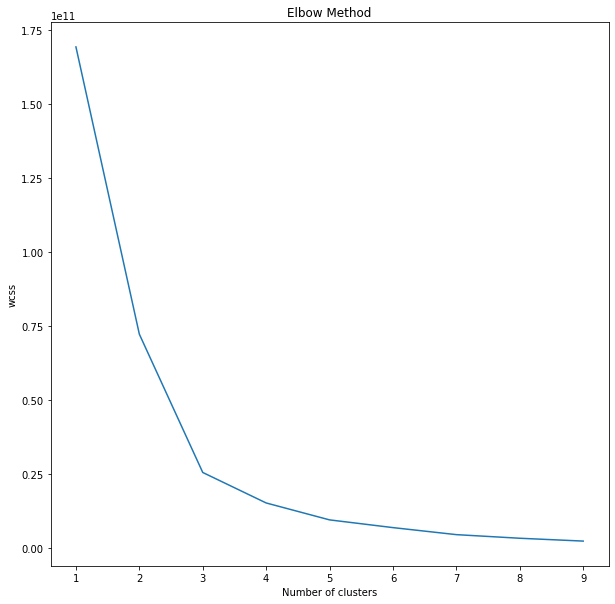

In [19]:
# import packages
from sklearn.cluster import KMeans

# Empty list for storing WCSS across all values of k
dist = []

# Iterate from 1-9
for i in range(1,10):
    # Initialize KMeans algorithm
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    # Fit on data
    km.fit(customers.iloc[:,1:7])
    # Append WCSS to list storing WCSS
    dist.append(km.inertia_)

# Initialize figure
plt.figure(figsize=(10,10))

# Line plot # clusters on X-axis and WCSS on Y-axis 
plt.plot(range(1,10),dist)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()


# Elbow Method
In the Elbow method, we are actually varying the number of clusters ( K ) from 1 – 10. For each value of K, we are calculating WCSS ( Within-Cluster Sum of Square ). WCSS is the sum of squared distance between each point and the centroid in a cluster. When we plot the WCSS with the K value, the plot looks like an Elbow. As the number of clusters increases, the WCSS value will start to decrease. WCSS value is largest when K = 1. When we analyze the graph we can see that the graph will rapidly change at a point and thus creating an elbow shape. From this point, the graph starts to move almost parallel to the X-axis. The K value corresponding to this point is the optimal K value or an optimal number of clusters.

# Use Kmeans to cluster data
The management has made a decision to segment customers into 3 categories in order to analyse customer behaviour. Now that you have data in the proper format, time to apply KMeans clustering algorithm to form the required 3 clusters and look if any such meaningful clusters are formed.

In [20]:
# initialize KMeans object
cluster = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)

Create a new column 'cluster' in the dataframe customers where you store the cluster centers for every observation from matrix. These cluster centers can be obtained using .fit_predict(customers.iloc[:,1:7]) method of customers. The first column isn't required as it contains the customer names.

In [21]:
# create 'cluster' column
customers['cluster'] = cluster.fit_predict(customers.iloc[:,1:7])

In [22]:
customers.head()

,CustomerID,Recency,Frequency,monetary,Recency_log,Frequency_log,Monetary_log,cluster
0,17850,372,34,5288.63,5.919163,3.526361,8.573333,0
1,13047,31,10,3079.10,3.437208,2.302585,8.032425,0
2,13748,95,5,948.25,4.554929,1.609438,6.854724,0
3,15100,333,3,635.10,5.808443,1.098612,6.453940,0
4,15291,25,15,4596.51,3.222868,2.708050,8.433074,0


In [23]:
customers.columns

Index(['CustomerID', 'Recency', 'Frequency', 'monetary', 'Recency_log',
       'Frequency_log', 'Monetary_log', 'cluster'],
      dtype='object')

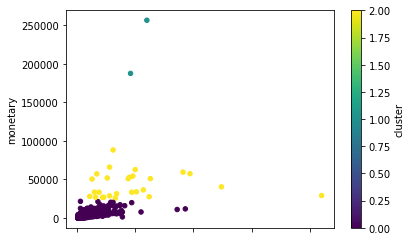

In [24]:
# plot the cluster
customers.plot.scatter(x= 'Frequency', y= 'monetary', c='cluster', colormap='viridis')
plt.xlabel("Frequency")
plt.show()


In [25]:
customers['cluster'].value_counts()

0    3892
2      27
1       2
Name: cluster, dtype: int64

In [26]:
customers.head()

,CustomerID,Recency,Frequency,monetary,Recency_log,Frequency_log,Monetary_log,cluster
0,17850,372,34,5288.63,5.919163,3.526361,8.573333,0
1,13047,31,10,3079.10,3.437208,2.302585,8.032425,0
2,13748,95,5,948.25,4.554929,1.609438,6.854724,0
3,15100,333,3,635.10,5.808443,1.098612,6.453940,0
4,15291,25,15,4596.51,3.222868,2.708050,8.433074,0
